In [1]:
from typing import List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def one_hot_encoding(mask, label_map):
    """
    Encodes mask/batch into one hot encoding.
    
    """
    ncols = max(label_map.values()) + 1
    out = np.zeros((mask.size, ncols), dtype=np.uint8)
    out[np.arange(mask.size), mask.ravel()] = 1
    out.shape = mask.shape + (ncols,)
    if 0 in label_map.values():
        return out
    return out[..., 1:]


class PixelLabelController():
    
    """
        This class keeps track of the number of pixels sampled for each label/class
        Based on this count a new label/class will be sampled. 
        Labels/Classes that have a higher count of pixels are sampled with a lower probabilty.
        
    
    """
    
    
    def __init__(self, labels: List[str], seed: int = 123):
        """
        Parameters
        ----------
        labels : List[int]
            list of label/class names.
            the index of the label in the list should correspond to the channel in the one-hot-encoded representation of the y_batch

        seed: random seed for numpy
        """
        
        self._labels = labels
        self._pixel_count_per_label = {label: 1 for label in self._labels}
        
        np.random.seed(seed)

    def __next__(self):
        ratios = self._compute_ratios()
        return np.random.choice(list(ratios.keys()), p=list(ratios.values()))

    
    def update(self, y_batch):
        for label, counts in self._one_hot_encoded_count(y_batch).items():
            self._pixel_count_per_label[label] += counts

    def _compute_ratios(self):
        total = sum(self._pixel_count_per_label.values())
        inverse_ratios = {
            label: 1 / (value / total)
            for label, value in self._pixel_count_per_label.items()
        }
        inverse_total = sum(inverse_ratios.values())
        ratios = {
            label: value / inverse_total for label, value in inverse_ratios.items()
        }
        return ratios
            
    def _one_hot_encoded_count(self, y_batch: np.ndarray) -> Dict[int, int]:
        inv_label_map_indexed = {
            label_index: label for label_index, label in enumerate(self._labels)
        }
        count_per_label = np.sum(y_batch, axis=tuple(range(len(y_batch.shape) - 1)))
        return {
            inv_label_map_indexed[label_index]: count
            for label_index, count in enumerate(count_per_label)
        }


In [2]:
# Here we define the label_map. The label map is a dictionary in which labels/classes are mapped to an integer. 
# The integer should represent the ground truth

label_map = {'dcis': 1, 'idc': 2, 'ilc': 3}


# below we make some example ground truth batches with a single label (one-hot-encoded) with (batchsize, width, height) dimensions

# an example batch with only dcis
dcis_ybatch = one_hot_encoding(np.ones((1, 128,128), dtype='uint8'), label_map)

# an example batch with only idc
idc_ybatch = one_hot_encoding(np.ones((1, 128,128),  dtype='uint8') * 2, label_map)

# an example batch with only ilc
ilc_ybatch = one_hot_encoding(np.ones((1, 128,128),  dtype='uint8') * 3, label_map)

# test if expected output
assert np.all(dcis_ybatch[..., 0] == 1)
assert np.all(idc_ybatch[..., 1] == 1)
assert np.all(ilc_ybatch[..., 2] == 1)

example_ground_truth = {'dcis': dcis_ybatch, 'idc': idc_ybatch, 'ilc': ilc_ybatch}

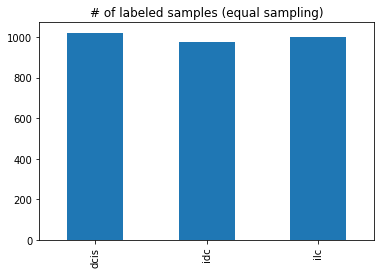

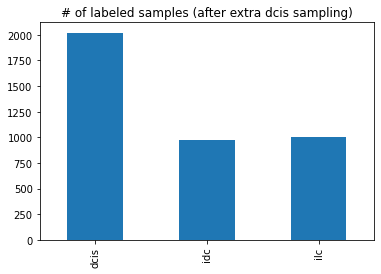

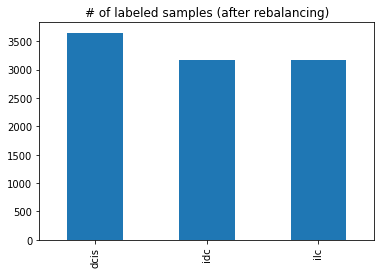

In [3]:
# Lets create the pixel label controller!
pixellabelcontroller = PixelLabelController(labels = list(label_map.keys()))

# list for keeping track of sampled labels
sampled_labels = []

# if no pixel were sampled each label should be sampled with the same probabilty

# sample new labels
for i in range(3000):
    #sample next label
    label = next(pixellabelcontroller)
    
    # keep track of sampled labels
    sampled_labels.append(label)
    
    # update the pixel label controller with ground truth values of the sampled label
    pixellabelcontroller.update(example_ground_truth[label])
    

pd.Series(sampled_labels).value_counts().reindex(["dcis", "idc", "ilc"]).plot(kind='bar')
plt.title('# of labeled samples (equal sampling)')
plt.show()


# EXTRA DCIS SAMPLING: sample a lot of dcis samples and update pixel counter with dcis ground truth
for i in range(1000):
    sampled_labels.append('dcis')
    pixellabelcontroller.update(dcis_ybatch)

pd.Series(sampled_labels).value_counts().reindex(["dcis", "idc", "ilc"]).plot(kind='bar')
plt.title('# of labeled samples (after extra dcis sampling)')
plt.show()


# REBALANCING: dcis should be now be sampled less often. 
for i in range(6000):
    
    #sample next label
    label = next(pixellabelcontroller)
    
    # keep track of sampled labels
    sampled_labels.append(label)
    
    # update the pixel label controller with ground truth values of the sampled label
    pixellabelcontroller.update(example_ground_truth[label])
    
pd.Series(sampled_labels).value_counts().reindex(["dcis", "idc", "ilc"]).plot(kind='bar')
plt.title('# of labeled samples (after rebalancing)')
plt.show()


